<a href="https://colab.research.google.com/github/NganTran-0017/HIDS/blob/main/ML_HIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Update remove duplicate between train and test --> create independent test
check why test set after removing the intersection (aka independent test) has no frequent record? --> no, set(independent test) has fewer records than independent test.
So the previous clean_data method removes duplication and overlap instances, while the new method (remove_duplicate) only removes overlap instance


!rm *.txt
! rm *.int

In [4]:
#@title Specify parameters before running


SZ =  1#@param {type:"number"}         # Indicate a fraction number to sample train set when it's too big. Located in Data Partition

SEQ_WINDOW =  25#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

BATCH_SZ =  32#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

EPOCHS =  2#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

# Indicate to clean data or not. Used in Data Cleaning section
CLEAN = True #@param {type:"boolean"}
DATA = "ADFA-LD" #@param {type:"string"}


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline

#import nltk
#nltk.download("popular")
## Tokenizing syscall sequences into n-grams of 6
#from nltk.tokenize import word_tokenize
#from nltk import ngrams

## **Preparing data for data partition**
- Combine data and labels together. 
- Combine data from each class together --> Create a pool of data 
- Split data pool into train and test

## **Cleaning**
- Remove dupplication between train and test

- 2 directions for Testing set:
  *  Test with clean data: Remove overlap and dupplication between Normal and Intrusion in Test data
  *  Test with Unclean data: Leave Test data as is

- 2 directions Training set:
  *   Clean model: Remove overlap and dupplication between Normal and Intrusion in Train data
  *   Unclean model: Leave Train data as is



#**Load partitioned data from here**

In [3]:
from google.colab import files
files.upload()

Saving ADFA-Duplication-test.zip to ADFA-Duplication-test.zip
Saving test_clean.csv to test_clean.csv
Saving test_unclean.csv to test_unclean.csv
Saving train_clean.csv to train_clean.csv


In [7]:
# Read in data
if CLEAN:   x_train = pd.read_csv('train_clean.csv', header = 0)
else:       x_train = pd.read_csv('train.csv.gz', header = 0, compression = 'gzip')
test_clean = pd.read_csv('test_clean.csv', header = 0)
test_unclean = pd.read_csv('test_unclean.csv', header = 0)

x_train.rename(columns = {'25': 'Label'}, inplace = True)
test_clean.rename(columns = {'25': 'Label'}, inplace = True)
test_unclean.rename(columns={'25':'Label'}, inplace=True)

In [8]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,Label
0,168,168,168,265,168,265,3,265,3,168,...,265,3,265,168,168,265,3,265,168,1
1,219,219,219,219,118,6,38,4,78,78,...,196,196,196,196,196,196,195,5,5,0
2,4,3,4,3,3,3,4,3,4,4,...,4,3,3,3,3,4,4,4,4,0
3,196,3,196,3,196,196,120,7,120,175,...,3,3,3,3,3,3,3,3,19,0
4,13,4,78,240,240,4,240,240,13,13,...,240,4,4,240,240,13,4,78,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336015,168,265,265,265,168,102,265,102,265,168,...,168,265,265,168,265,102,102,265,168,0
336016,265,3,168,168,265,3,265,168,265,3,...,265,265,265,3,168,168,265,168,168,1
336017,6,142,3,4,119,6,7,33,5,140,...,120,6,3,6,102,102,102,102,221,0
336018,43,168,265,43,168,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1


In [9]:
test_clean

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,Label
0,4,4,3,4,4,3,4,4,4,4,...,4,4,4,3,4,4,4,4,3,0
1,168,3,168,168,168,168,168,78,168,265,...,168,168,168,146,3,265,168,168,168,1
2,54,309,309,54,3,54,54,54,54,54,...,54,54,54,309,54,54,54,54,54,1
3,3,3,168,3,168,3,168,19,168,265,...,3,146,4,168,168,3,3,4,168,1
4,5,3,162,141,3,3,3,3,3,192,...,5,3,5,6,5,91,3,5,91,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136864,3,142,104,3,265,104,104,175,175,3,...,175,3,142,142,175,265,175,142,3,1
136865,4,3,3,3,4,3,4,33,3,3,...,4,3,33,33,192,33,3,3,3,0
136866,43,43,3,265,43,168,3,3,265,43,...,3,3,168,265,168,43,168,43,43,1
136867,265,142,265,104,3,104,104,3,3,104,...,3,3,142,142,142,3,265,104,3,1


In [10]:
# Separate data and label
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)

y_test_clean = test_clean['Label']
test_clean.drop(columns = 'Label', inplace=True)

y_test_unclean = test_unclean['Label']
test_unclean.drop(columns = 'Label', inplace=True)

In [13]:
!unzip ADFA-Duplication-test.zip -d /content/test

Archive:  ADFA-Duplication-test.zip
  inflating: /content/test/ADFA-10-dup-test.csv  
  inflating: /content/test/ADFA-15-dup-test.csv  
  inflating: /content/test/ADFA-20-dup-test.csv  
  inflating: /content/test/ADFA-25-dup-test.csv  
  inflating: /content/test/ADFA-30-dup-test.csv  
  inflating: /content/test/ADFA-35-dup-test.csv  
  inflating: /content/test/ADFA-40-dup-test.csv  
  inflating: /content/test/ADFA-45-dup-test.csv  
  inflating: /content/test/ADFA-50-dup-test.csv  
  inflating: /content/test/ADFA-55-dup-test.csv  
  inflating: /content/test/ADFA-5-dup-test.csv  
  inflating: /content/test/ADFA-60-dup-test.csv  
  inflating: /content/test/ADFA-65-dup-test.csv  
  inflating: /content/test/ADFA-70-dup-test.csv  
  inflating: /content/test/ADFA-75-dup-test.csv  
  inflating: /content/test/ADFA-80-dup-test.csv  
  inflating: /content/test/ADFA-85-dup-test.csv  
  inflating: /content/test/ADFA-90-dup-test.csv  
  inflating: /content/test/ADFA-95-dup-test.csv  
  inflating: /c

In [24]:
os.listdir('/content/test/')

['ADFA-90-dup-test.csv',
 'ADFA-30-dup-test.csv',
 'ADFA-85-dup-test.csv',
 'ADFA-95-dup-test.csv',
 'ADFA-75-dup-test.csv',
 'ADFA-10-dup-test.csv',
 'ADFA-60-dup-test.csv',
 'ADFA-25-dup-test.csv',
 'ADFA-45-dup-test.csv',
 'ADFA-55-dup-test.csv',
 'ADFA-40-dup-test.csv',
 'ADFA-15-dup-test.csv',
 'ADFA-80-dup-test.csv',
 'ADFA-20-dup-test.csv',
 'ADFA-65-dup-test.csv',
 'ADFA-35-dup-test.csv',
 'ADFA-50-dup-test.csv',
 'ADFA-70-dup-test.csv',
 'ADFA-5-dup-test.csv']

In [26]:
# Get a list of testing files
import os
test_list = os.listdir('/content/test/')
test_files = []
for f in test_list:
  test_files.append(pd.read_csv('/content/test/'+f, sep=',', header=0))

# Get duplication order
dup_order = []
for f in test_list:
  tokens = f.split('-')
  dup_order.append(int(tokens[1])) # change to 1 for adfa

test_list, dup_order

(['ADFA-90-dup-test.csv',
  'ADFA-30-dup-test.csv',
  'ADFA-85-dup-test.csv',
  'ADFA-95-dup-test.csv',
  'ADFA-75-dup-test.csv',
  'ADFA-10-dup-test.csv',
  'ADFA-60-dup-test.csv',
  'ADFA-25-dup-test.csv',
  'ADFA-45-dup-test.csv',
  'ADFA-55-dup-test.csv',
  'ADFA-40-dup-test.csv',
  'ADFA-15-dup-test.csv',
  'ADFA-80-dup-test.csv',
  'ADFA-20-dup-test.csv',
  'ADFA-65-dup-test.csv',
  'ADFA-35-dup-test.csv',
  'ADFA-50-dup-test.csv',
  'ADFA-70-dup-test.csv',
  'ADFA-5-dup-test.csv'],
 [90, 30, 85, 95, 75, 10, 60, 25, 45, 55, 40, 15, 80, 20, 65, 35, 50, 70, 5])

In [28]:
# for ADFA data only
for f in test_files:
  f.drop(columns='Unnamed: 0', inplace = True)

In [29]:
test_files[0]

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,Label
0,3,265,168,265,3,265,168,265,3,265,...,168,265,3,265,168,265,168,168,168,1
1,175,175,142,265,142,146,142,146,265,142,...,3,104,3,3,265,142,265,146,146,1
2,78,102,168,102,168,168,102,168,168,91,...,168,168,102,168,102,168,102,168,168,1
3,168,168,146,168,265,265,3,168,168,146,...,3,3,265,168,168,265,168,168,168,1
4,43,168,168,3,168,168,168,168,168,168,...,195,3,265,168,43,3,3,168,168,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136864,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,3,3,4,3,0
136865,43,168,168,3,168,3,3,265,265,3,...,168,3,3,3,3,168,265,265,3,1
136866,43,168,265,168,168,168,168,168,168,168,...,168,168,265,168,3,168,265,3,265,1
136867,196,240,240,240,240,240,78,265,240,240,...,240,240,265,240,240,240,265,240,240,0


 ## **Clean Train**
 Remove rows that exist in both normal and intrusion and rows that frequently appear within each class

In [30]:
## Get % of duplicates in both datasets

# Convert normal df to set, and intrusion df to set
def clean_data(normal, intrusion):
  normal_list = normal.values.tolist()
  intrusion_list = intrusion.values.tolist()
  normal_set = set(tuple(i) for i in normal_list)
  intrusion_set = set(tuple(i) for i in intrusion_list)
  print('List sz vs. Set sz of normal sequences: %d vs. %d'% (len(normal_list),len(normal_set)) )
  print('List sz vs. Set sz of intrusion sequences: %d vs. %d'% (len(intrusion_list),len(intrusion_set)) )
    
  normal_dupplication = (len(normal_list) - len(normal_set)) /len(normal_list)*100 
  intrusion_duplication = (len(intrusion_list)-len(intrusion_set))/len(intrusion_list) * 100

  print('Duplication Rate in Normal Class: %.3f%%'% normal_dupplication )
  print('Duplication Rate in Intrusion Class: %.3f%%'% intrusion_duplication) 
 
  c_intrusion = intrusion_set - normal_set 
  overlap_rate =  len(normal_set.intersection(intrusion_set)) / len(normal_set.union(intrusion_set)) * 100
  print('Overlap rate: %.3f%%' % overlap_rate)
  
  #c_normal = normal_set - intrusion_set
  if len(c_intrusion) == 0:
    print(DATA+' No Duplication!')
  if len(c_intrusion) > 0:
    intrusion = pd.DataFrame(c_intrusion)
  else:
    intrusion = pd.DataFrame(intrusion_set)
  #if len(c_normal) > 0:
  #  normal = pd.DataFrame(c_normal)
  #else:
  normal = pd.DataFrame(normal_set)

  print('After cleaning: \nNormal sz:', len(normal), ' Intrusion sz:', len(c_intrusion) )
  return normal, intrusion


# If the CLEAN parameter at the top is checked, we'll train the model with clean data
if CLEAN:
  filt = y_train == 0
  train_normal = x_train.loc[filt]
  train_intrusion = x_train.loc[~filt]
  normal, intrusion = clean_data(train_normal, train_intrusion) # clean normal and intrusion in Train 

  normal['Label'] = 0; intrusion['Label'] = 1
  x_train = normal.append(intrusion, ignore_index = True)
  x_train = x_train.sample(frac = 1)
  x_train.reset_index(drop=True, inplace = True)
  y_train = x_train['Label']
  x_train.drop(columns = 'Label', inplace = True)

List sz vs. Set sz of normal sequences: 126355 vs. 126355
List sz vs. Set sz of intrusion sequences: 209665 vs. 209665
Duplication Rate in Normal Class: 0.000%
Duplication Rate in Intrusion Class: 0.000%
Overlap rate: 0.000%
After cleaning: 
Normal sz: 126355  Intrusion sz: 209665


In [31]:
#x_train['Label'] = y_train
#x_train.to_csv('train_clean.csv', index=False)
x_train

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,140,5,197,5,197,197,5,5,197,197,...,4,4,4,4,4,4,4,4,4,4
1,146,146,146,163,163,146,163,146,163,146,...,146,163,146,163,146,163,146,163,146,163
2,168,3,3,265,168,168,168,3,168,3,...,168,265,265,265,168,3,168,340,3,168
3,3,3,3,168,3,168,3,3,168,265,...,265,265,265,3,3,265,3,168,265,3
4,221,221,221,221,221,221,221,168,102,4,...,4,4,168,42,221,4,168,168,4,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336015,91,201,206,5,6,5,221,220,220,6,...,5,197,5,3,3,3,102,168,3,91
336016,265,265,102,265,265,265,168,168,168,168,...,168,168,265,265,265,168,265,168,168,265
336017,168,168,168,102,265,168,168,102,168,168,...,168,265,168,265,168,265,265,168,168,265
336018,5,13,3,4,78,102,168,168,168,168,...,78,102,168,102,168,168,168,13,195,13


If there is not enough data from either class, bootstrap to generate more data and create a balanced sample

In [33]:
# Separate normal and intrusion in Test Clean so that I can call func clean_data on them
def separate_two_classes (data, label):
  ## Filter normal data from Test and drop label column
  filt = label == 0
  normal_class = data.loc[filt]
  #normal_class.drop(columns = 'Label', inplace = True)

  ## Filter Intrusion data from Test and drop label column
  intrusion_class = data.loc[~filt]
  #intrusion_class.drop(columns = 'Label', inplace = True)
  return normal_class, intrusion_class

normal_train, intrusion_train = separate_two_classes(x_train, y_train)

In [34]:
# Bootstrap training data

## Lived-name has more intrusion cases than normal cases (189 > 71) --> bootstrap normal cases only
x_train['Label'] = y_train
if len(intrusion_train) > len(normal_train):
  x_train = x_train.iloc[intrusion_train.index].append(x_train.iloc[normal_train.index].sample(n = len(intrusion_train), replace=True), ignore_index=True) #upsampled normal data and add to train set
else:
  x_train = x_train.iloc[normal_train.index].append(x_train.iloc[intrusion_train.index].sample(n = len(normal_train), replace=True), ignore_index=True) #upsampled intrusion data and add to train set

#x_train = x_train.append(x_train.sample(frac=1), ignore_index=True) # Bootstrap training data in case there is not enough data
x_train = x_train.sample(frac= SZ) # Shuffle data with a SZ proportion
x_train.reset_index(drop=True, inplace=True)
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)
x_train

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,91,91,195,5,6,33,6,197,33,125,...,102,5,125,33,6,6,5,331,5,3
1,4,265,265,13,240,265,13,240,78,4,...,4,78,13,13,78,13,13,4,13,13
2,3,4,4,4,3,3,4,3,4,3,...,4,3,4,4,4,4,4,3,4,4
3,168,3,168,168,168,265,168,168,168,168,...,168,265,168,168,168,3,168,168,168,168
4,78,78,78,78,199,6,3,78,140,78,...,78,78,78,78,78,78,78,78,78,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419325,168,265,168,168,168,265,265,168,265,168,...,3,168,168,3,168,265,168,265,3,3
419326,5,4,197,192,33,5,33,5,33,3,...,3,3,3,3,3,3,3,45,3,3
419327,78,240,240,240,78,240,265,240,240,78,...,78,78,78,240,240,265,78,78,78,240
419328,168,3,3,168,3,3,3,168,3,3,...,3,3,3,3,3,168,146,168,3,3


In [36]:
test_unclean.shape, test_clean.shape

((137855, 25), (136869, 25))


# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale






In [37]:
clean_status = 'clean' if CLEAN else 'unclean'

# This function calculate False Positive Rate given a confusion matrix
def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels):
  clean_status = 'clean' if CLEAN else 'unclean'

  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  outfile = open('{}-{}-Models-Output.txt'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Output.txt
  outfile.write('\nConfusion Matrix: ' + str(cmatrix))
  outfile.write('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  outfile.write('\nPrecision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  outfile.write('\nRecall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  outfile.write('\nFalse Positive Rate: %.2f'% fpr)
  outfile.write('\nClassification report:\n'+  str(classification_report(true_labels, pred_labels)) )
  outfile.write('AUC: %.2f \n\n'% roc_auc_score(true_labels, pred_labels))

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))
  
  outfile.close()
  
  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  if CLEAN: clean_status='Clean '
  else: clean_status ='Overlapped and Duplicated '
  plt.title( model_name+' ROC Curve on '+ clean_status + DATA + ' with Seq Len of '+ str(SEQ_WINDOW))
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.1])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)


# Save performance measure dict of each model to a file
def write_to_file (varname, model_name, clean):
  filename = DATA +'-'+ str(SEQ_WINDOW) +'-'+ clean_status + "-model.txt"
  file = open(filename, "a")
  str_dictionary = repr(varname)
  file.write("{}_test_{} = ".format(model_name, clean) + str_dictionary + "\n")
  file.close()

# This func takes in Test sets to evaluate model. Make it convenient when testing with clean and unclean data
def test_model(data, label, model, model_name, clean):
  if model_name == 'NN':
    y_predicted = np.argmax(model.predict(data), axis=-1)
  else:
    y_predicted = model.predict(data)

  outfile = open('{}-{}-Models-Output.txt'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Output.txt
  outfile.write('\n-------------------- {} on {} data --------------------'.format(model_name, clean))
  outfile.close()
  print('--------------------' + model_name + ' on ' + clean + ' data --------------------')
  print_performance(model_name, label, y_predicted)

  # Recording TPR and FPR for the TESTING ROC curves
  performance = {}
  performance['fpr'], performance['tpr'], thresh = roc_curve(label, y_predicted)
  performance['auc'] = roc_auc_score(label, y_predicted)
  print('Test AUC: %.3f' %(performance['auc']))

  return performance

# **K-means**

In [38]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score

# Choose K cluster = 2
kmeans = KMeans(n_clusters=2)
# Fit Kmeans to the training set
kmeans.fit(x_train)

# Number of iterations before converging
print('Number of iterations before converging:', kmeans.n_iter_)

Number of iterations before converging: 11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------KM on clean data --------------------
Confusion Matrix: 
 [[17343 30517]
 [64535 24474]]

Testing Accuracy: 0.31
Precision:0.45
Recall: 0.27
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.45      0.27      0.34     89009

    accuracy                           0.31    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.31      0.31    136869

AUC: 0.32


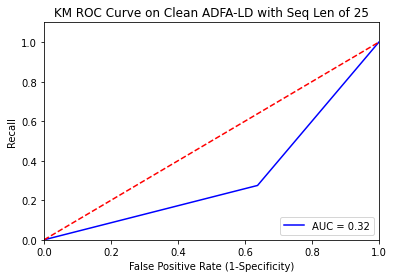

Test AUC: 0.319



--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17631 31047]
 [64614 24563]]

Testing Accuracy: 0.31
Precision:0.44
Recall: 0.28
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     48678
           1       0.44      0.28      0.34     89177

    accuracy                           0.31    137855
   macro avg       0.33      0.32      0.30    137855
weighted avg       0.36      0.31      0.31    137855

AUC: 0.32


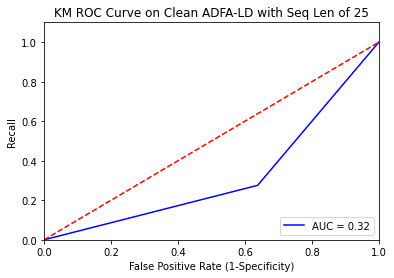

Test AUC: 0.319


In [39]:
## TESTING K-MEANS with clean data and unclean data
KM_clean_perf   = test_model(test_clean, y_test_clean, kmeans, 'KM', 'clean'); print('\n\n')
KM_unclean_perf = test_model(test_unclean, y_test_unclean, kmeans, 'KM', 'unclean')

write_to_file(KM_clean_perf, 'KM', 'clean')
write_to_file(KM_unclean_perf, 'KM', 'unclean')

---------------------Testing with 90% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------KM on unclean data --------------------
Confusion Matrix: 
 [[17145 30715]
 [64544 24465]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.27
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.26     47860
           1       0.44      0.27      0.34     89009

    accuracy                           0.30    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.30      0.31    136869

AUC: 0.32


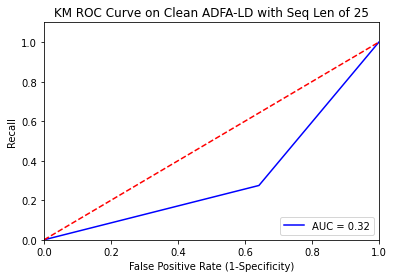

Test AUC: 0.317


---------------------Testing with 30% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17375 30485]
 [64444 24565]]

Testing Accuracy: 0.31
Precision:0.45
Recall: 0.28
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.45      0.28      0.34     89009

    accuracy                           0.31    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.31      0.32    136869

AUC: 0.32


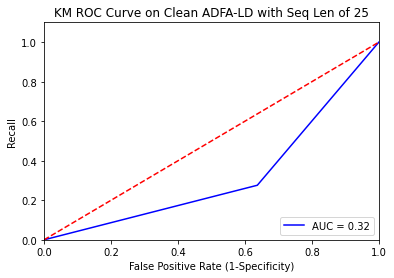

Test AUC: 0.320


---------------------Testing with 85% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17103 30757]
 [64374 24635]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.28
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.26     47860
           1       0.44      0.28      0.34     89009

    accuracy                           0.30    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.30      0.31    136869

AUC: 0.32


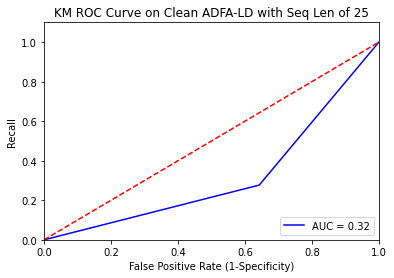

Test AUC: 0.317


---------------------Testing with 95% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17043 30817]
 [64214 24795]]

Testing Accuracy: 0.31
Precision:0.45
Recall: 0.28
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.26     47860
           1       0.45      0.28      0.34     89009

    accuracy                           0.31    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.31      0.32    136869

AUC: 0.32


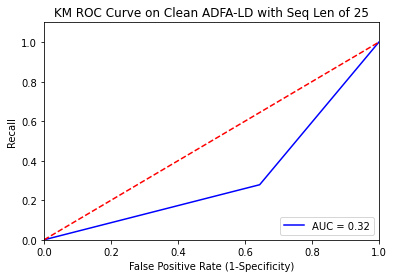

Test AUC: 0.317


---------------------Testing with 75% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17445 30415]
 [64734 24275]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.27
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.44      0.27      0.34     89009

    accuracy                           0.30    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.30      0.31    136869

AUC: 0.32


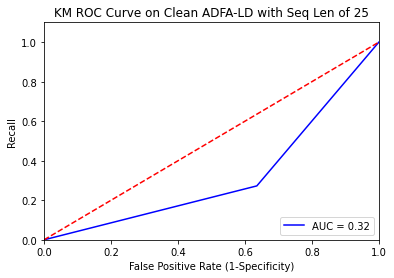

Test AUC: 0.319


---------------------Testing with 10% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17332 30528]
 [64530 24479]]

Testing Accuracy: 0.31
Precision:0.45
Recall: 0.28
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.45      0.28      0.34     89009

    accuracy                           0.31    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.31      0.31    136869

AUC: 0.32


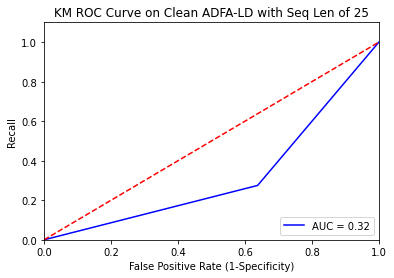

Test AUC: 0.319


---------------------Testing with 60% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17704 30156]
 [64421 24588]]

Testing Accuracy: 0.31
Precision:0.45
Recall: 0.28
False Positive Rate: 0.63

Classification report:
              precision    recall  f1-score   support

           0       0.22      0.37      0.27     47860
           1       0.45      0.28      0.34     89009

    accuracy                           0.31    136869
   macro avg       0.33      0.32      0.31    136869
weighted avg       0.37      0.31      0.32    136869

AUC: 0.32


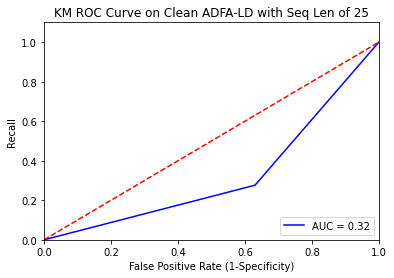

Test AUC: 0.323


---------------------Testing with 25% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17303 30557]
 [64582 24427]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.27
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.44      0.27      0.34     89009

    accuracy                           0.30    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.30      0.31    136869

AUC: 0.32


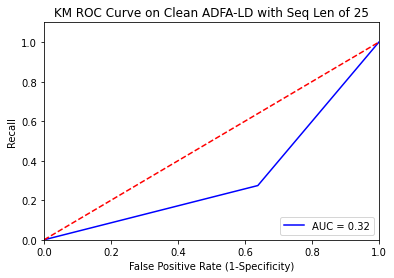

Test AUC: 0.318


---------------------Testing with 45% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17335 30525]
 [64537 24472]]

Testing Accuracy: 0.31
Precision:0.44
Recall: 0.27
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.44      0.27      0.34     89009

    accuracy                           0.31    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.31      0.31    136869

AUC: 0.32


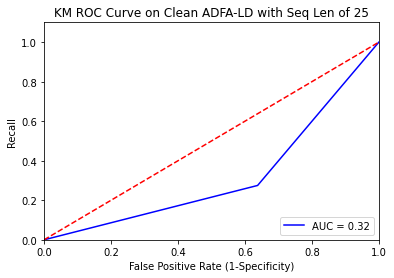

Test AUC: 0.319


---------------------Testing with 55% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17338 30522]
 [64694 24315]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.27
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.44      0.27      0.34     89009

    accuracy                           0.30    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.30      0.31    136869

AUC: 0.32


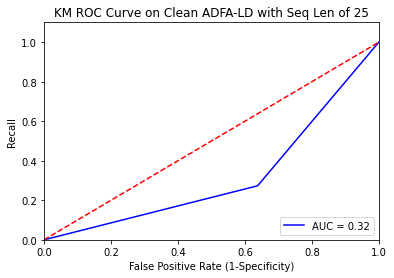

Test AUC: 0.318


---------------------Testing with 40% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17449 30411]
 [64765 24244]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.27
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.44      0.27      0.34     89009

    accuracy                           0.30    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.30      0.31    136869

AUC: 0.32


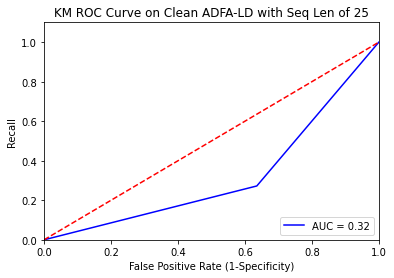

Test AUC: 0.318


---------------------Testing with 15% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17282 30578]
 [64561 24448]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.27
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.44      0.27      0.34     89009

    accuracy                           0.30    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.30      0.31    136869

AUC: 0.32


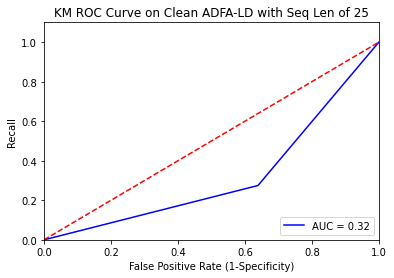

Test AUC: 0.318


---------------------Testing with 80% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17481 30379]
 [64755 24254]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.27
False Positive Rate: 0.63

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.37      0.27     47860
           1       0.44      0.27      0.34     89009

    accuracy                           0.30    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.30      0.31    136869

AUC: 0.32


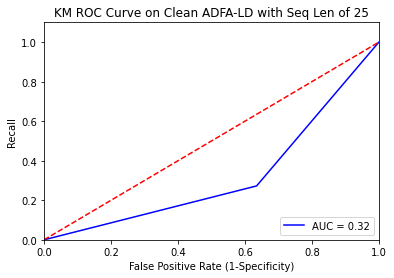

Test AUC: 0.319


---------------------Testing with 20% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17349 30511]
 [64567 24442]]

Testing Accuracy: 0.31
Precision:0.44
Recall: 0.27
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.44      0.27      0.34     89009

    accuracy                           0.31    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.31      0.31    136869

AUC: 0.32


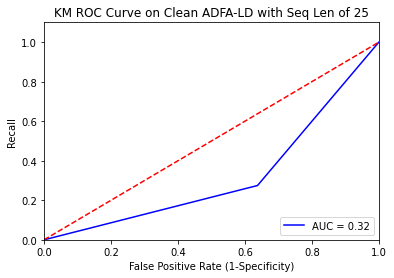

Test AUC: 0.319


---------------------Testing with 65% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17436 30424]
 [64378 24631]]

Testing Accuracy: 0.31
Precision:0.45
Recall: 0.28
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.45      0.28      0.34     89009

    accuracy                           0.31    136869
   macro avg       0.33      0.32      0.31    136869
weighted avg       0.37      0.31      0.32    136869

AUC: 0.32


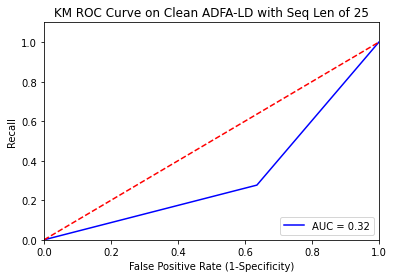

Test AUC: 0.321


---------------------Testing with 35% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17282 30578]
 [64703 24306]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.27
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.44      0.27      0.34     89009

    accuracy                           0.30    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.30      0.31    136869

AUC: 0.32


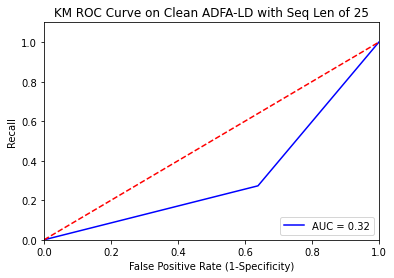

Test AUC: 0.317


---------------------Testing with 50% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17324 30536]
 [64682 24327]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.27
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.44      0.27      0.34     89009

    accuracy                           0.30    136869
   macro avg       0.33      0.32      0.30    136869
weighted avg       0.36      0.30      0.31    136869

AUC: 0.32


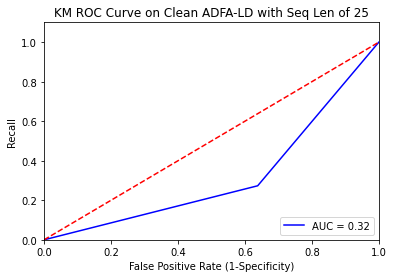

Test AUC: 0.318


---------------------Testing with 70% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[17233 30627]
 [64158 24851]]

Testing Accuracy: 0.31
Precision:0.45
Recall: 0.28
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.36      0.27     47860
           1       0.45      0.28      0.34     89009

    accuracy                           0.31    136869
   macro avg       0.33      0.32      0.31    136869
weighted avg       0.37      0.31      0.32    136869

AUC: 0.32


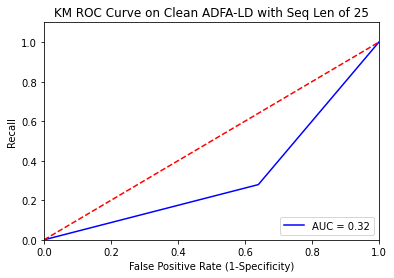

Test AUC: 0.320


---------------------Testing with 5% duplication---------------------
--------------------KM on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[16551 31309]
 [63976 25033]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.28
False Positive Rate: 0.65

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.35      0.26     47860
           1       0.44      0.28      0.34     89009

    accuracy                           0.30    136869
   macro avg       0.32      0.31      0.30    136869
weighted avg       0.36      0.30      0.31    136869

AUC: 0.31


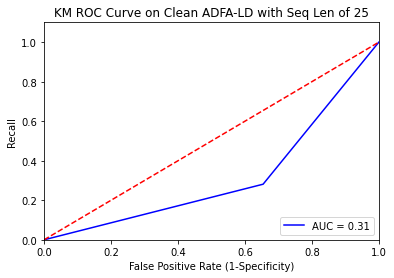

Test AUC: 0.314




In [40]:
def test_with_duplication(model, model_name):
  i = 0
  for f in test_files:
    label = f['Label']; data = f.drop(columns = ['Label'])

    outfile = open('{}-{}-Models-Output.txt'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Output.txt
    outfile.write('---------------------Testing with %d%% duplication---------------------'% dup_order[i])
    outfile.close()
    print('---------------------Testing with %d%% duplication---------------------'% dup_order[i])
    test_model(data, label, model, model_name, 'unclean'); print('\n')
    i+=1
  outfile = open('{}-{}-Models-Output.txt'.format(DATA, clean_status), "a")  # Live-Named-Clean-Models-Output.txt
  outfile.write('---------------------------------Finish---------------------------------')
  outfile.close()

test_with_duplication(kmeans, 'KM')

# **Logistic Regression**

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------LR on clean data --------------------
Confusion Matrix: 
 [[31968 15892]
 [26601 62408]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.68


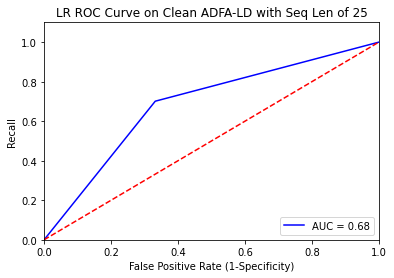

Test AUC: 0.685



--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[32530 16148]
 [26692 62485]]

Testing Accuracy: 0.69
Precision:0.79
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     48678
           1       0.79      0.70      0.74     89177

    accuracy                           0.69    137855
   macro avg       0.67      0.68      0.67    137855
weighted avg       0.71      0.69      0.69    137855

AUC: 0.68


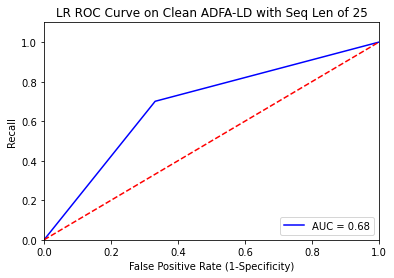

Test AUC: 0.684


In [41]:
from sklearn.linear_model import LogisticRegression

# Fit the model on the training set
lgModel = LogisticRegression().fit(x_train, y_train)

## TESTING Logistic Regression with clean data and unclean data
LR_clean_perf   = test_model(test_clean, y_test_clean, lgModel, 'LR', 'clean'); print('\n\n')
LR_unclean_perf = test_model(test_unclean, y_test_unclean, lgModel, 'LR', 'unclean')

In [42]:
# Save performance to text file
write_to_file(LR_clean_perf, 'LR', 'clean')
write_to_file(LR_unclean_perf, 'LR', 'unclean')

---------------------Testing with 90% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31840 16020]
 [26566 62443]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.69    136869

AUC: 0.68


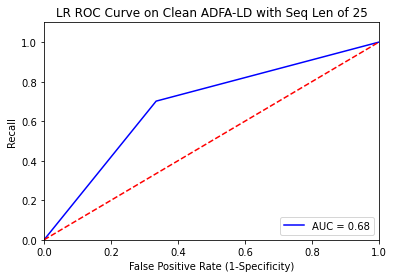

Test AUC: 0.683


---------------------Testing with 30% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31982 15878]
 [26714 62295]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.69    136869

AUC: 0.68


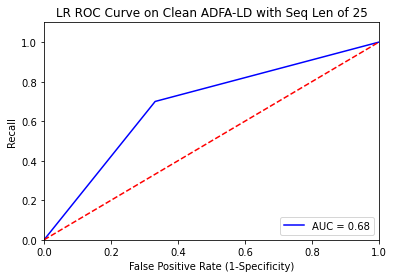

Test AUC: 0.684


---------------------Testing with 85% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[32154 15706]
 [26701 62308]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.69      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.69


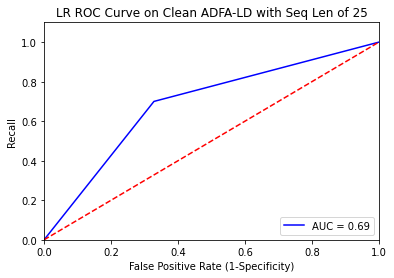

Test AUC: 0.686


---------------------Testing with 95% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[32091 15769]
 [26761 62248]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.68


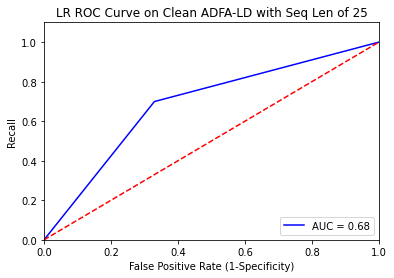

Test AUC: 0.685


---------------------Testing with 75% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31978 15882]
 [26591 62418]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.68


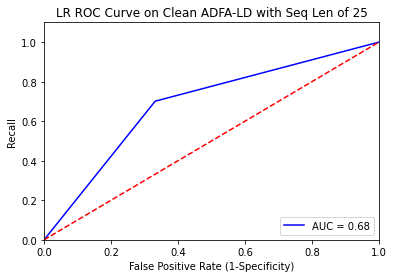

Test AUC: 0.685


---------------------Testing with 10% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31964 15896]
 [26624 62385]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.68


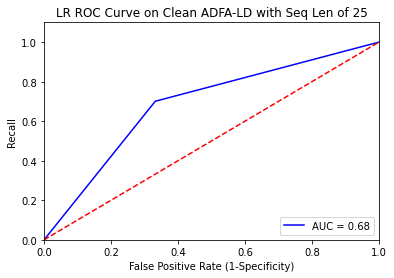

Test AUC: 0.684


---------------------Testing with 60% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31671 16189]
 [26736 62273]]

Testing Accuracy: 0.69
Precision:0.79
Recall: 0.70
False Positive Rate: 0.34

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.66      0.60     47860
           1       0.79      0.70      0.74     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.69    136869

AUC: 0.68


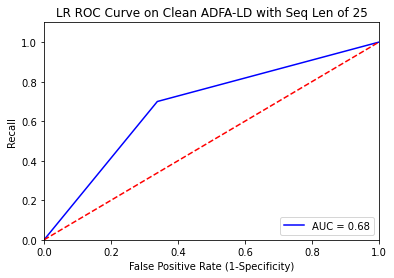

Test AUC: 0.681


---------------------Testing with 25% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[32029 15831]
 [26559 62450]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.69      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.69


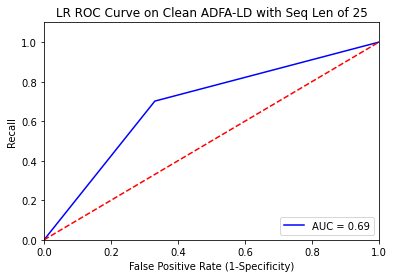

Test AUC: 0.685


---------------------Testing with 45% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31913 15947]
 [26622 62387]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.69    136869

AUC: 0.68


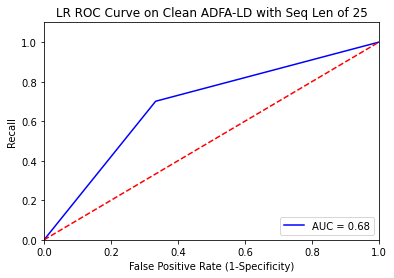

Test AUC: 0.684


---------------------Testing with 55% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31843 16017]
 [26487 62522]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.68


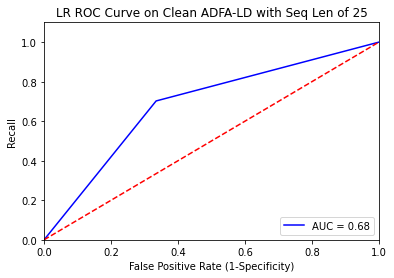

Test AUC: 0.684


---------------------Testing with 40% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31958 15902]
 [26334 62675]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.69      0.68    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.69


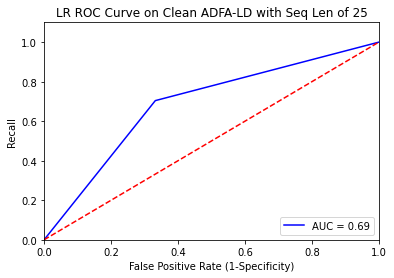

Test AUC: 0.686


---------------------Testing with 15% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[32041 15819]
 [26595 62414]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.69      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.69


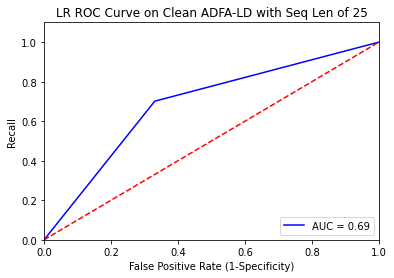

Test AUC: 0.685


---------------------Testing with 80% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31812 16048]
 [26294 62715]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.34

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.66      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.68


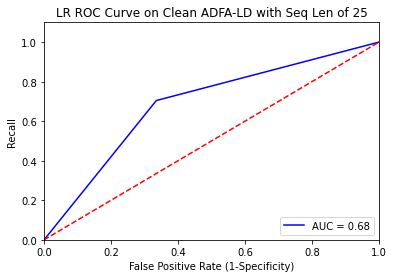

Test AUC: 0.685


---------------------Testing with 20% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31987 15873]
 [26577 62432]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.68


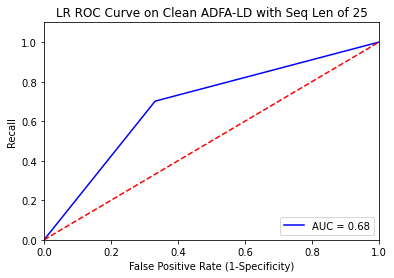

Test AUC: 0.685


---------------------Testing with 65% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31888 15972]
 [26851 62158]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60     47860
           1       0.80      0.70      0.74     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.69    136869

AUC: 0.68


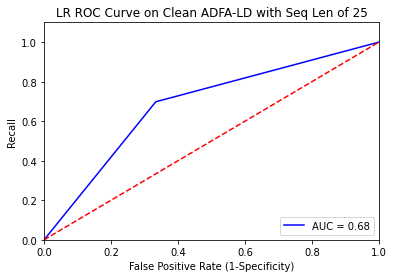

Test AUC: 0.682


---------------------Testing with 35% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[32036 15824]
 [26488 62521]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.69      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.69


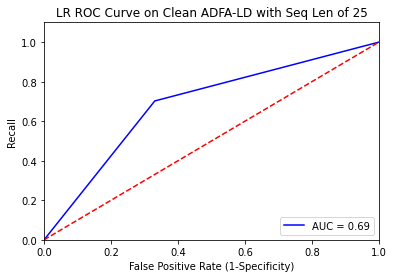

Test AUC: 0.686


---------------------Testing with 50% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[31995 15865]
 [26405 62604]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60     47860
           1       0.80      0.70      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.69      0.67    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.69


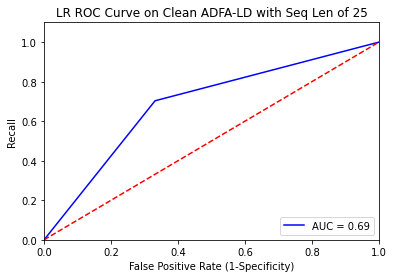

Test AUC: 0.686


---------------------Testing with 70% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[32017 15843]
 [27102 61907]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.70
False Positive Rate: 0.33

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60     47860
           1       0.80      0.70      0.74     89009

    accuracy                           0.69    136869
   macro avg       0.67      0.68      0.67    136869
weighted avg       0.71      0.69      0.69    136869

AUC: 0.68


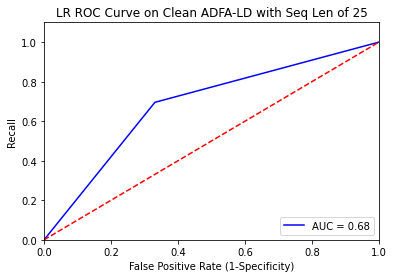

Test AUC: 0.682


---------------------Testing with 5% duplication---------------------
--------------------LR on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[32795 15065]
 [27226 61783]]

Testing Accuracy: 0.69
Precision:0.80
Recall: 0.69
False Positive Rate: 0.31

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.69      0.61     47860
           1       0.80      0.69      0.75     89009

    accuracy                           0.69    136869
   macro avg       0.68      0.69      0.68    136869
weighted avg       0.71      0.69      0.70    136869

AUC: 0.69


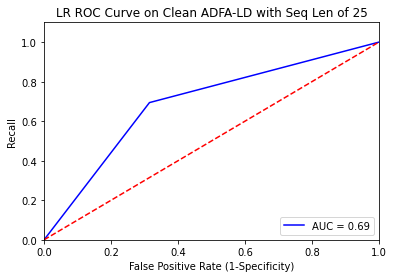

Test AUC: 0.690




In [43]:
# Test with Duplication 
test_with_duplication(lgModel, 'LR')

# **SVM**

This model uses a Polynomial kernel, and the rest of the parameters are as default






In [44]:
if len(x_train) > 500000: 
  svm_sz = 0.05  
elif len(x_train) > 100000:
  svm_sz = 0.2
else:
  svm_sz = 1

svm_sz

0.2

In [45]:

train_data = x_train.copy(deep=True) # create a deep copy of x_train, so any modification to train_data won't affect x_train
train_data['Label'] = y_train
train_data = train_data.groupby('Label').sample(frac = svm_sz)
train_data.reset_index(drop=True, inplace= True)

svm_x_train = train_data.drop(columns='Label')
svm_y_train = train_data['Label']
svm_x_train

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,63,6,6,174,11,11,11,11,45,33,...,6,33,5,3,197,192,192,6,33,5
1,201,13,102,102,102,142,13,4,199,195,...,91,5,140,197,192,140,91,6,5,140
2,195,120,6,114,42,6,6,120,114,114,...,114,3,5,221,6,221,63,6,120,63
3,3,3,3,3,3,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,4
4,221,221,221,221,168,3,6,4,168,168,...,4,168,168,6,4,168,168,4,168,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83861,146,3,168,146,168,265,168,265,168,168,...,265,265,265,3,146,3,168,168,265,168
83862,168,43,265,3,265,168,43,3,265,265,...,168,43,3,3,168,168,3,168,168,265
83863,146,168,168,168,168,265,168,3,168,265,...,3,168,168,168,168,168,146,168,265,168
83864,4,13,4,4,265,4,240,13,13,4,...,13,4,78,240,240,13,240,240,13,240



****Polynomial kernel model: 


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on clean data --------------------
Confusion Matrix: 
 [[37952  9908]
 [32538 56471]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.63      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


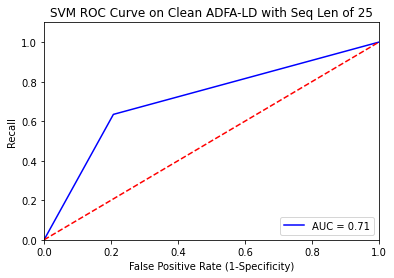

Test AUC: 0.714





/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38656 10022]
 [32663 56514]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     48678
           1       0.85      0.63      0.73     89177

    accuracy                           0.69    137855
   macro avg       0.70      0.71      0.69    137855
weighted avg       0.74      0.69      0.70    137855

AUC: 0.71


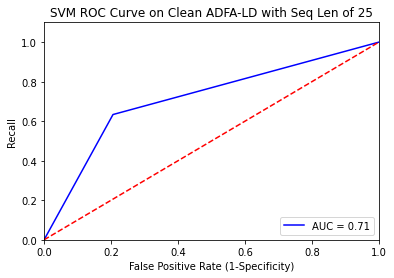

Test AUC: 0.714


In [46]:
from sklearn import svm

#### Create a SVM classifier using polynomial Kernel
print('\n****Polynomial kernel model: ')
svm_model = svm.SVC(kernel = 'poly')

#Train the  & Get accuracy from training
svm_model.fit(svm_x_train, svm_y_train)

## TESTING SVM with clean data and unclean data
SVM_clean_perf   = test_model(test_clean,   y_test_clean,   svm_model, 'SVM', 'clean'); print('\n\n')
SVM_unclean_perf = test_model(test_unclean, y_test_unclean, svm_model, 'SVM', 'unclean')

# Save performance to text file
write_to_file(SVM_clean_perf, 'SVM', 'clean')
write_to_file(SVM_unclean_perf, 'SVM', 'unclean')

---------------------Testing with 90% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38073  9787]
 [32526 56483]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.20

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.80      0.64     47860
           1       0.85      0.63      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.70      0.72      0.69    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.72


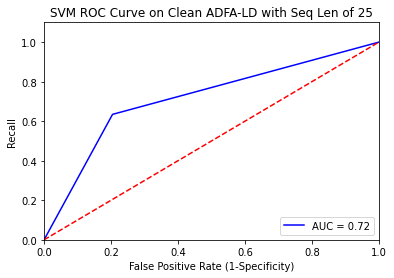

Test AUC: 0.715


---------------------Testing with 30% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38063  9797]
 [32640 56369]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.20

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.80      0.64     47860
           1       0.85      0.63      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.70      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


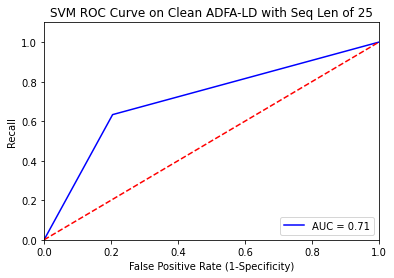

Test AUC: 0.714


---------------------Testing with 85% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38029  9831]
 [32876 56133]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.63      0.72     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


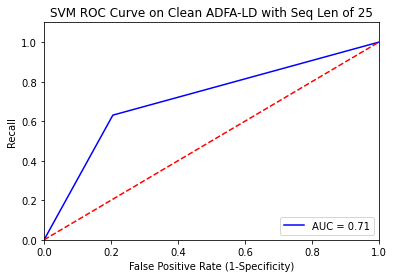

Test AUC: 0.713


---------------------Testing with 95% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38011  9849]
 [32328 56681]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.64
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.64      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.70      0.72      0.69    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.72


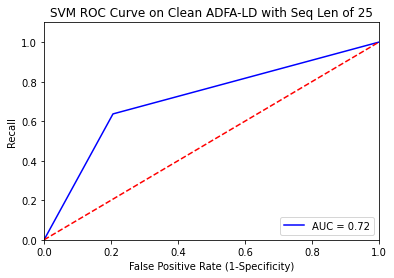

Test AUC: 0.716


---------------------Testing with 75% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38057  9803]
 [32658 56351]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.20

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.80      0.64     47860
           1       0.85      0.63      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


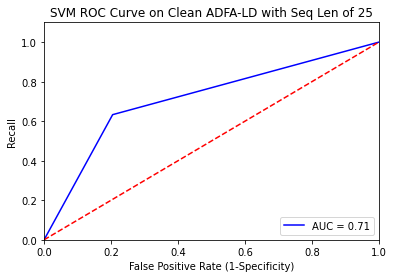

Test AUC: 0.714


---------------------Testing with 10% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[37985  9875]
 [32518 56491]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.63      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


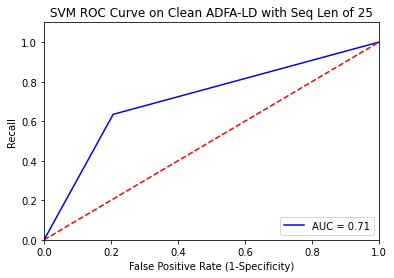

Test AUC: 0.714


---------------------Testing with 60% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[37767 10093]
 [32635 56374]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.63      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.69    136869

AUC: 0.71


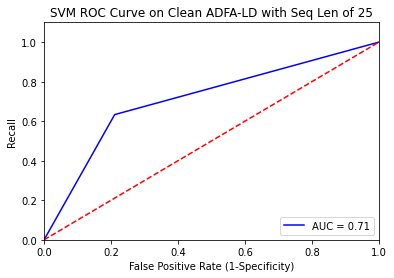

Test AUC: 0.711


---------------------Testing with 25% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[37933  9927]
 [32591 56418]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.63      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


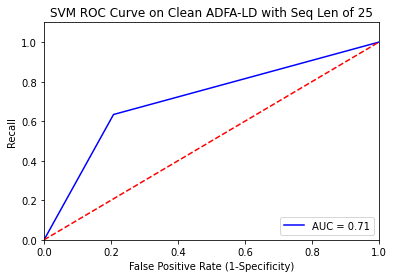

Test AUC: 0.713


---------------------Testing with 45% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38001  9859]
 [32869 56140]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.63      0.72     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.69    136869

AUC: 0.71


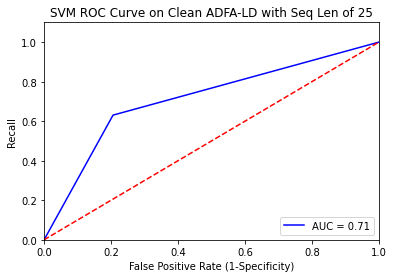

Test AUC: 0.712


---------------------Testing with 55% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[37833 10027]
 [32388 56621]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.64
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.64      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


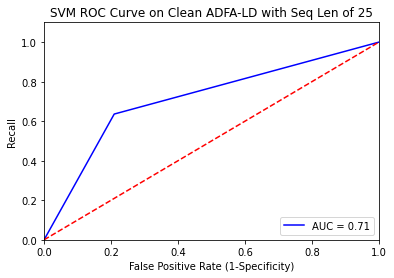

Test AUC: 0.713


---------------------Testing with 40% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[37951  9909]
 [32426 56583]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.64
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.64      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.70      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


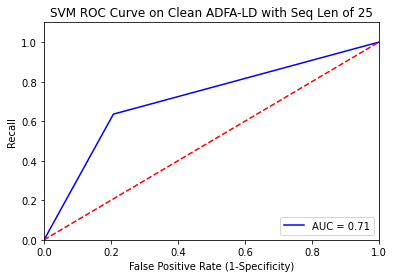

Test AUC: 0.714


---------------------Testing with 15% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[37942  9918]
 [32675 56334]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.63      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


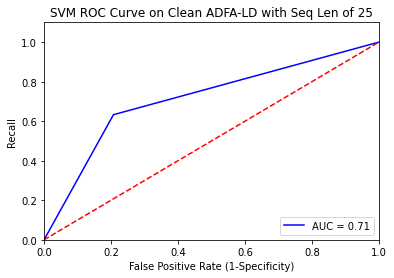

Test AUC: 0.713


---------------------Testing with 80% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[37815 10045]
 [32326 56683]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.64
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.64      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


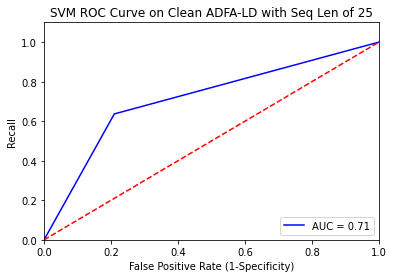

Test AUC: 0.713


---------------------Testing with 20% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38064  9796]
 [32564 56445]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.20

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.80      0.64     47860
           1       0.85      0.63      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.70      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


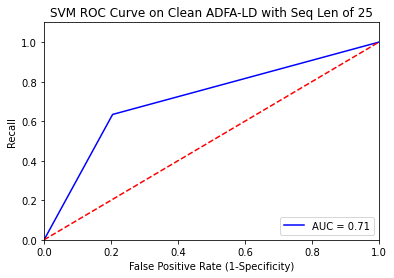

Test AUC: 0.715


---------------------Testing with 65% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[37996  9864]
 [32715 56294]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.63      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


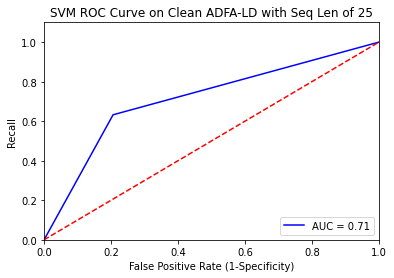

Test AUC: 0.713


---------------------Testing with 35% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38025  9835]
 [32485 56524]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.64
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     47860
           1       0.85      0.64      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.70      0.71      0.69    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


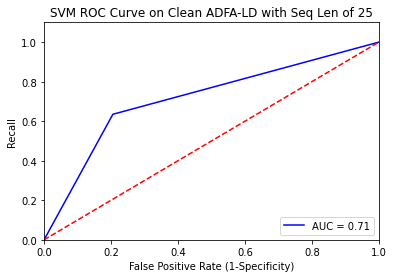

Test AUC: 0.715


---------------------Testing with 50% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38054  9806]
 [32477 56532]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.64
False Positive Rate: 0.20

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.80      0.64     47860
           1       0.85      0.64      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.70      0.72      0.69    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.72


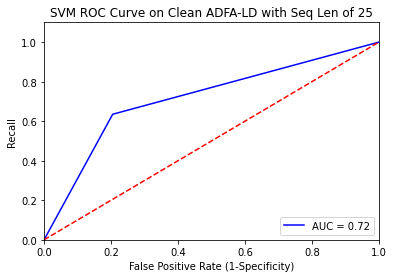

Test AUC: 0.715


---------------------Testing with 70% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38092  9768]
 [32886 56123]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.63
False Positive Rate: 0.20

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.80      0.64     47860
           1       0.85      0.63      0.72     89009

    accuracy                           0.69    136869
   macro avg       0.69      0.71      0.68    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.71


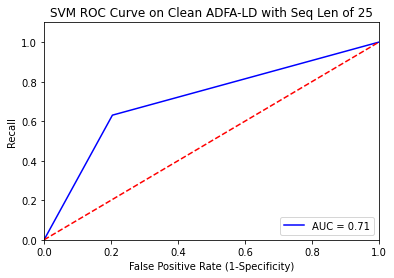

Test AUC: 0.713


---------------------Testing with 5% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[38107  9753]
 [32261 56748]]

Testing Accuracy: 0.69
Precision:0.85
Recall: 0.64
False Positive Rate: 0.20

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.80      0.64     47860
           1       0.85      0.64      0.73     89009

    accuracy                           0.69    136869
   macro avg       0.70      0.72      0.69    136869
weighted avg       0.74      0.69      0.70    136869

AUC: 0.72


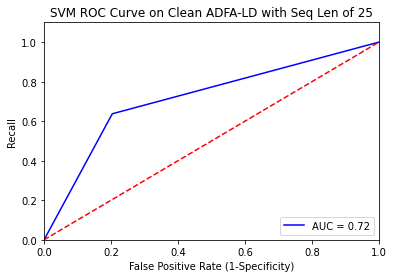

Test AUC: 0.717




In [47]:
# Test with Duplication 
test_with_duplication(svm_model, 'SVM')

 Plot a heatmap confusion matrix
color_confusion_matrix('SVM', svm_model, x_test, y_test, y_predicted)

# **Neural Net**

This model contains 3 layers: input layer of 6 nodes, a fully connected layer of 6 nodes and an output layer of 2 nodes

In [48]:
# Scale syscall number to between 0 and 1
# The maximum syscall number in UNM data is 181
max_syscall = 181
x_train_nn = x_train/max_syscall
clean_x_test_nn = test_clean/max_syscall
unclean_x_test_nn =  test_unclean/max_syscall

In [49]:
import tensorflow as tf
from tensorflow import keras
INPUT_SZ = len(x_train.columns)
nn_model = keras.Sequential([
    keras.layers.Input(shape = (INPUT_SZ,)),           # model expect input to be a vector of 6 numbers
    keras.layers.Dense(INPUT_SZ, activation = 'relu'), 
    keras.layers.Dense(2, activation = 'sigmoid')
])

nn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to training set
history = nn_model.fit(x_train_nn, y_train, epochs=10, batch_size= 32, verbose=1)  

Epoch 1/10
13105/13105 [==============================] - 25s 2ms/step - loss: 0.6038 - accuracy: 0.6826
Epoch 2/10
13105/13105 [==============================] - 25s 2ms/step - loss: 0.5877 - accuracy: 0.6925
Epoch 3/10
13105/13105 [==============================] - 24s 2ms/step - loss: 0.5630 - accuracy: 0.7124
Epoch 4/10
13105/13105 [==============================] - 26s 2ms/step - loss: 0.5296 - accuracy: 0.7465
Epoch 5/10
13105/13105 [==============================] - 25s 2ms/step - loss: 0.5068 - accuracy: 0.7694
Epoch 6/10
13105/13105 [==============================] - 25s 2ms/step - loss: 0.4986 - accuracy: 0.7757
Epoch 7/10
13105/13105 [==============================] - 25s 2ms/step - loss: 0.4931 - accuracy: 0.7803
Epoch 8/10
13105/13105 [==============================] - 25s 2ms/step - loss: 0.4887 - accuracy: 0.7842
Epoch 9/10
13105/13105 [==============================] - 25s 2ms/step - loss: 0.4838 - accuracy: 0.7890
Epoch 10/10
13105/13105 [==============================

--------------------NN on clean data --------------------
Confusion Matrix: 
 [[37652 10208]
 [18180 70829]]

Testing Accuracy: 0.79
Precision:0.87
Recall: 0.80
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.79      0.73     47860
           1       0.87      0.80      0.83     89009

    accuracy                           0.79    136869
   macro avg       0.77      0.79      0.78    136869
weighted avg       0.80      0.79      0.80    136869

AUC: 0.79


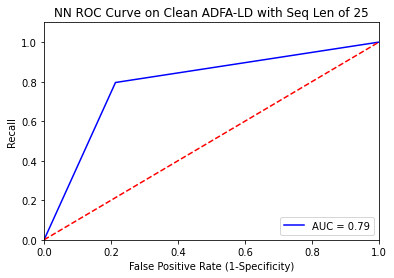

Test AUC: 0.791



--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[38322 10356]
 [18241 70936]]

Testing Accuracy: 0.79
Precision:0.87
Recall: 0.80
False Positive Rate: 0.21

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73     48678
           1       0.87      0.80      0.83     89177

    accuracy                           0.79    137855
   macro avg       0.78      0.79      0.78    137855
weighted avg       0.80      0.79      0.80    137855

AUC: 0.79


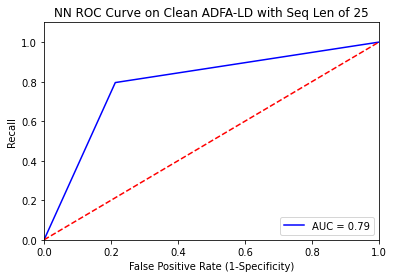

Test AUC: 0.791


In [50]:
# Get predicted Training labels
#y_pred = np.argmax(nn_model.predict(x_train_nn), axis=-1)

## TESTING NN with clean data and unclean data
NN_clean_perf   = test_model(clean_x_test_nn,   y_test_clean,   nn_model, 'NN', 'clean'); print('\n\n')
NN_unclean_perf = test_model(unclean_x_test_nn, y_test_unclean, nn_model, 'NN', 'unclean')

In [51]:
nn_model.summary()

#history.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                650       
                                                                 
 dense_1 (Dense)             (None, 2)                 52        
                                                                 
Total params: 702
Trainable params: 702
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Save performance to text file
write_to_file(NN_clean_perf, 'NN', 'clean')
write_to_file(NN_unclean_perf, 'NN', 'unclean')

---------------------Testing with 90% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   83 47777]
 [    0 89009]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.83      0.50      0.40    136869
weighted avg       0.77      0.65      0.51    136869

AUC: 0.50


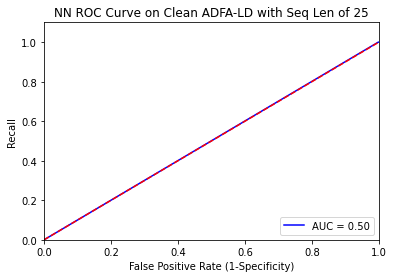

Test AUC: 0.501


---------------------Testing with 30% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   65 47795]
 [    5 89004]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.79      0.50      0.40    136869
weighted avg       0.75      0.65      0.51    136869

AUC: 0.50


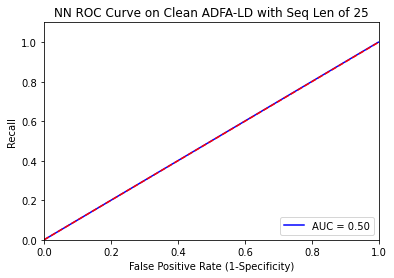

Test AUC: 0.501


---------------------Testing with 85% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   89 47771]
 [    3 89006]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.81      0.50      0.40    136869
weighted avg       0.76      0.65      0.51    136869

AUC: 0.50


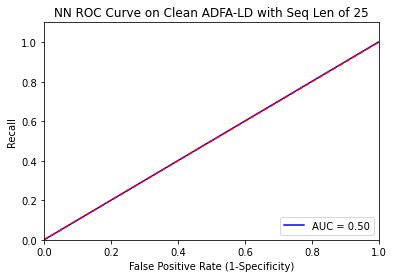

Test AUC: 0.501


---------------------Testing with 95% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   70 47790]
 [    9 89000]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.77      0.50      0.40    136869
weighted avg       0.73      0.65      0.51    136869

AUC: 0.50


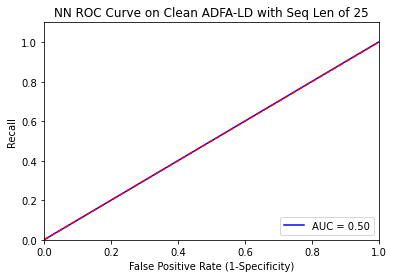

Test AUC: 0.501


---------------------Testing with 75% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   83 47777]
 [    3 89006]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.81      0.50      0.40    136869
weighted avg       0.76      0.65      0.51    136869

AUC: 0.50


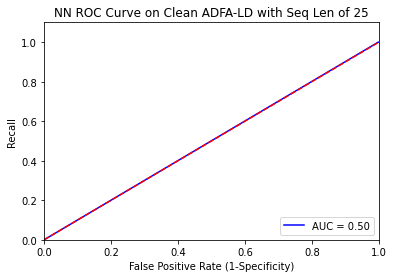

Test AUC: 0.501


---------------------Testing with 10% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   67 47793]
 [    5 89004]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.79      0.50      0.40    136869
weighted avg       0.75      0.65      0.51    136869

AUC: 0.50


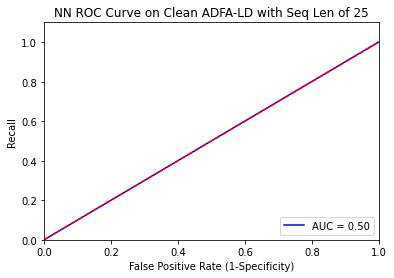

Test AUC: 0.501


---------------------Testing with 60% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   72 47788]
 [    4 89005]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.80      0.50      0.40    136869
weighted avg       0.75      0.65      0.51    136869

AUC: 0.50


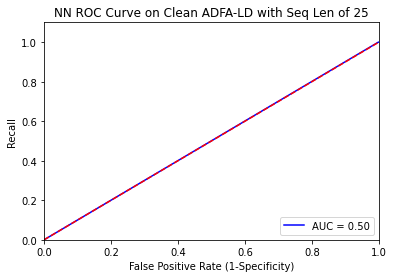

Test AUC: 0.501


---------------------Testing with 25% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   72 47788]
 [    6 89003]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.79      0.50      0.40    136869
weighted avg       0.75      0.65      0.51    136869

AUC: 0.50


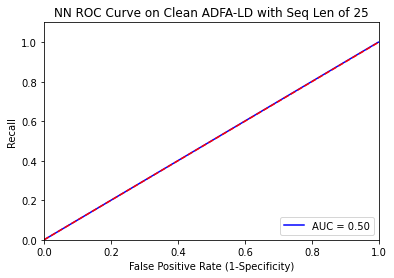

Test AUC: 0.501


---------------------Testing with 45% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   57 47803]
 [    7 89002]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.77      0.50      0.40    136869
weighted avg       0.73      0.65      0.51    136869

AUC: 0.50


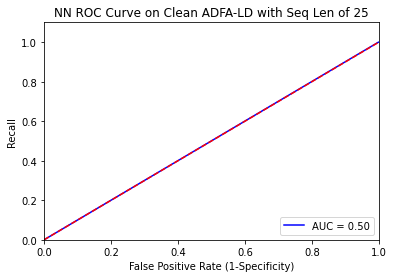

Test AUC: 0.501


---------------------Testing with 55% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   55 47805]
 [    6 89003]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.78      0.50      0.40    136869
weighted avg       0.74      0.65      0.51    136869

AUC: 0.50


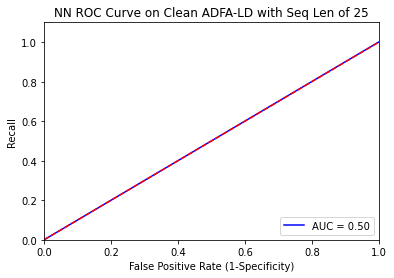

Test AUC: 0.501


---------------------Testing with 40% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   59 47801]
 [    4 89005]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.79      0.50      0.40    136869
weighted avg       0.75      0.65      0.51    136869

AUC: 0.50


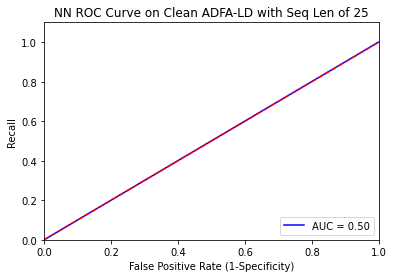

Test AUC: 0.501


---------------------Testing with 15% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   68 47792]
 [    5 89004]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.79      0.50      0.40    136869
weighted avg       0.75      0.65      0.51    136869

AUC: 0.50


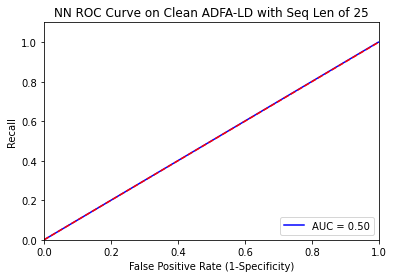

Test AUC: 0.501


---------------------Testing with 80% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   55 47805]
 [    7 89002]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.77      0.50      0.40    136869
weighted avg       0.73      0.65      0.51    136869

AUC: 0.50


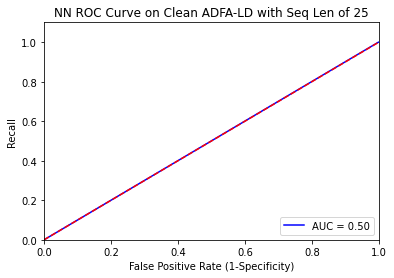

Test AUC: 0.501


---------------------Testing with 20% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   63 47797]
 [    4 89005]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.80      0.50      0.40    136869
weighted avg       0.75      0.65      0.51    136869

AUC: 0.50


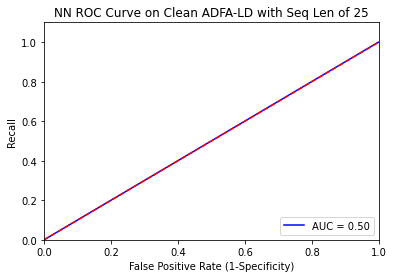

Test AUC: 0.501


---------------------Testing with 65% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   60 47800]
 [    3 89006]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.80      0.50      0.40    136869
weighted avg       0.76      0.65      0.51    136869

AUC: 0.50


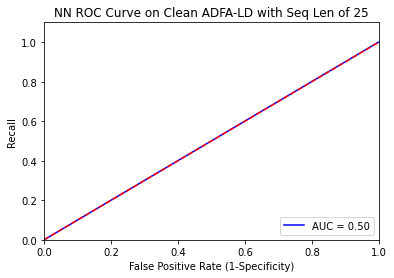

Test AUC: 0.501


---------------------Testing with 35% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   70 47790]
 [    6 89003]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.79      0.50      0.40    136869
weighted avg       0.75      0.65      0.51    136869

AUC: 0.50


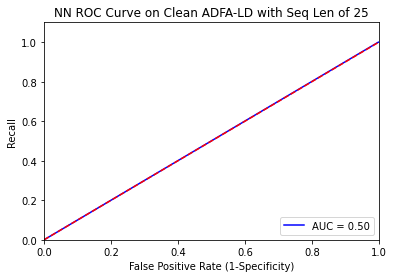

Test AUC: 0.501


---------------------Testing with 50% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   67 47793]
 [    3 89006]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.80      0.50      0.40    136869
weighted avg       0.76      0.65      0.51    136869

AUC: 0.50


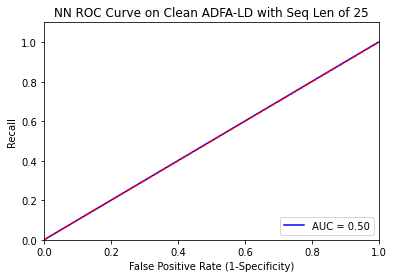

Test AUC: 0.501


---------------------Testing with 70% duplication---------------------
--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[   63 47797]
 [    3 89006]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.80      0.50      0.40    136869
weighted avg       0.76      0.65      0.51    136869

AUC: 0.50


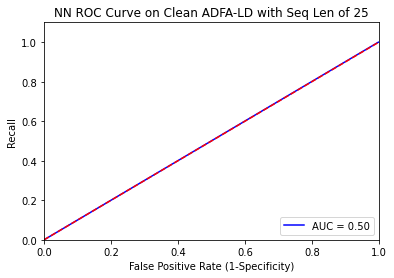

Test AUC: 0.501


---------------------Testing with 5% duplication---------------------
--------------------NN on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix: 
 [[    0 47860]
 [    0 89009]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 1.00
False Positive Rate: 1.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     47860
           1       0.65      1.00      0.79     89009

    accuracy                           0.65    136869
   macro avg       0.33      0.50      0.39    136869
weighted avg       0.42      0.65      0.51    136869

AUC: 0.50


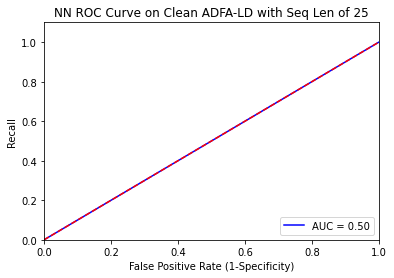

Test AUC: 0.500




In [53]:
# Test with Duplication 
test_with_duplication(nn_model, 'NN')

# **Decision Tree**

This model uses GINI criterion to split the data and requires at least 10 observations to split and 5 observations in the leaf.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------DT on clean data --------------------
Confusion Matrix: 
 [[39379  8481]
 [10917 78092]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


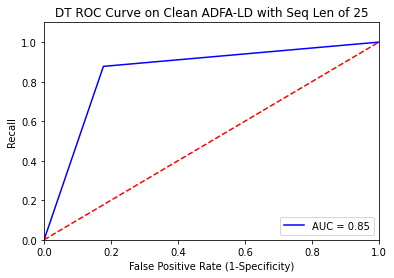

Test AUC: 0.850



--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[40106  8572]
 [10962 78215]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80     48678
           1       0.90      0.88      0.89     89177

    accuracy                           0.86    137855
   macro avg       0.84      0.85      0.85    137855
weighted avg       0.86      0.86      0.86    137855

AUC: 0.85


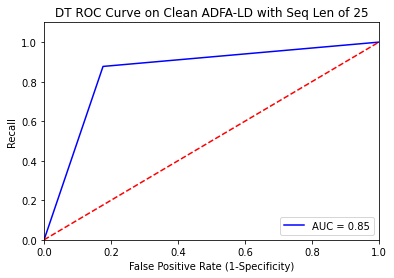

Test AUC: 0.850
---------------------Testing with 90% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39446  8414]
 [10769 78240]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


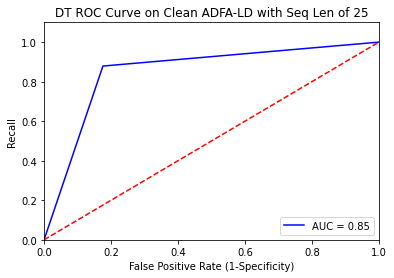

Test AUC: 0.852


---------------------Testing with 30% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39469  8391]
 [11077 77932]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


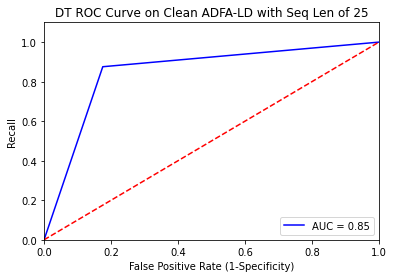

Test AUC: 0.850


---------------------Testing with 85% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39239  8621]
 [10618 78391]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


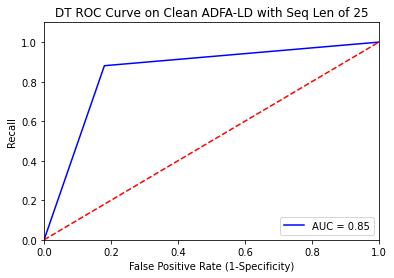

Test AUC: 0.850


---------------------Testing with 95% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39807  8053]
 [10435 78574]]

Testing Accuracy: 0.86
Precision:0.91
Recall: 0.88
False Positive Rate: 0.17

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     47860
           1       0.91      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.85      0.86      0.85    136869
weighted avg       0.87      0.86      0.87    136869

AUC: 0.86


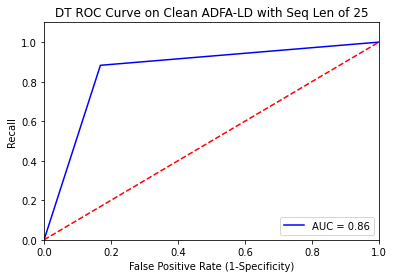

Test AUC: 0.857


---------------------Testing with 75% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39431  8429]
 [11039 77970]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


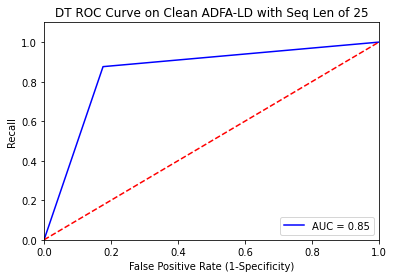

Test AUC: 0.850


---------------------Testing with 10% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39409  8451]
 [10932 78077]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


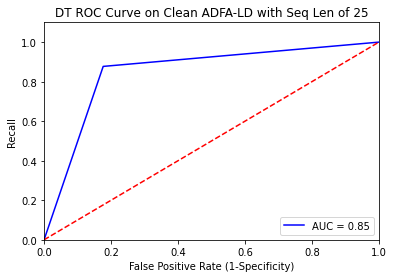

Test AUC: 0.850


---------------------Testing with 60% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39308  8552]
 [10874 78135]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


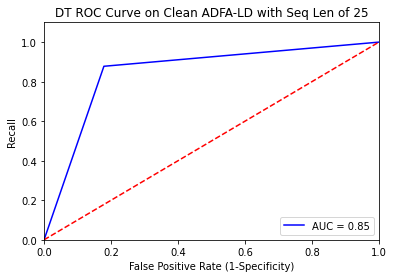

Test AUC: 0.850


---------------------Testing with 25% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39438  8422]
 [10924 78085]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


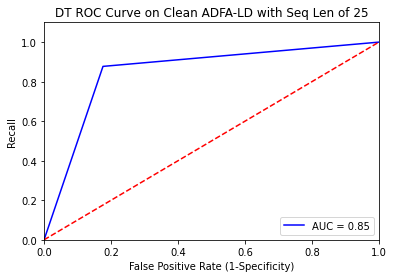

Test AUC: 0.851


---------------------Testing with 45% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39466  8394]
 [11092 77917]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


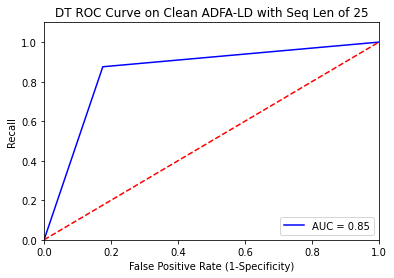

Test AUC: 0.850


---------------------Testing with 55% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39345  8515]
 [10816 78193]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


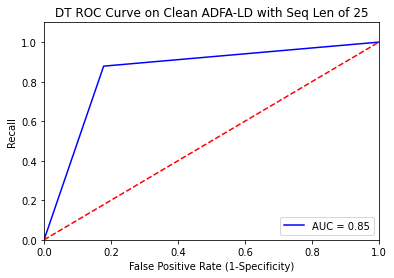

Test AUC: 0.850


---------------------Testing with 40% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39406  8454]
 [10859 78150]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


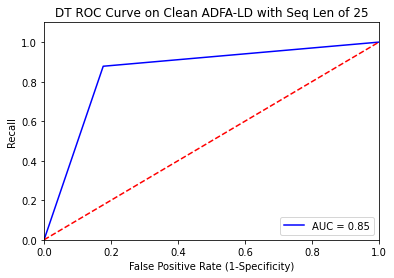

Test AUC: 0.851


---------------------Testing with 15% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39354  8506]
 [10974 78035]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


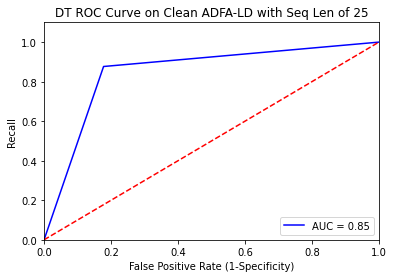

Test AUC: 0.849


---------------------Testing with 80% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39561  8299]
 [10798 78211]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.17

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


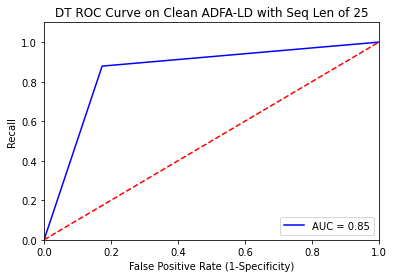

Test AUC: 0.853


---------------------Testing with 20% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39453  8407]
 [10988 78021]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


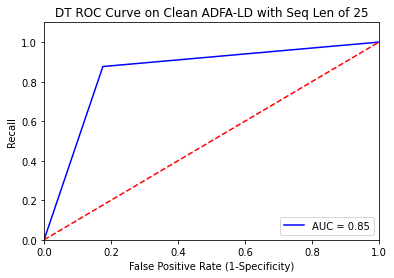

Test AUC: 0.850


---------------------Testing with 65% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39484  8376]
 [10839 78170]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


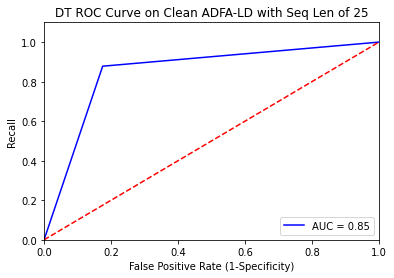

Test AUC: 0.852


---------------------Testing with 35% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39387  8473]
 [10845 78164]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


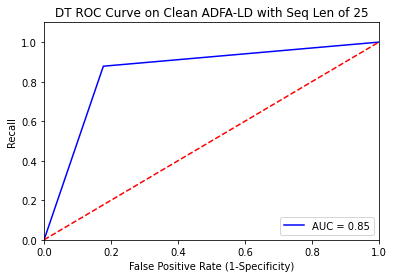

Test AUC: 0.851


---------------------Testing with 50% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39307  8553]
 [10902 78107]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


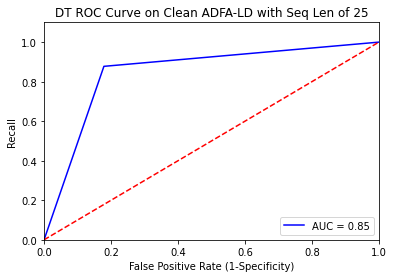

Test AUC: 0.849


---------------------Testing with 70% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39338  8522]
 [10910 78099]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


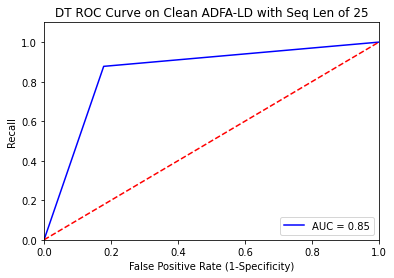

Test AUC: 0.850


---------------------Testing with 5% duplication---------------------
--------------------DT on unclean data --------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Confusion Matrix: 
 [[39220  8640]
 [10731 78278]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80     47860
           1       0.90      0.88      0.89     89009

    accuracy                           0.86    136869
   macro avg       0.84      0.85      0.85    136869
weighted avg       0.86      0.86      0.86    136869

AUC: 0.85


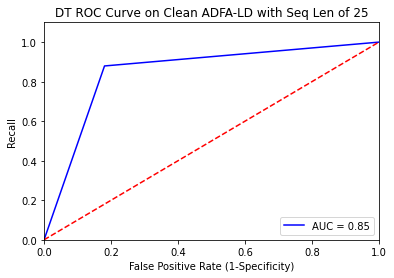

Test AUC: 0.849




In [54]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, y_train)

## TESTING DT with clean data and unclean data
DT_clean_perf   = test_model(test_clean,   y_test_clean,   decTree, 'DT', 'clean'); print('\n\n')
DT_unclean_perf = test_model(test_unclean, y_test_unclean, decTree, 'DT', 'unclean')

# Save performance to text file
write_to_file( DT_clean_perf, 'DT', 'clean')
write_to_file( DT_unclean_perf, 'DT', 'unclean')

# Test with Duplication 
test_with_duplication(decTree, 'DT')

# **Random Forest**

This model has no max depth and allows bootstrapping observations during training. It uses GINI criterion to split and requires a minimum of 10 observations to split and the leaf node must have above 5 observations.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on clean data --------------------
Confusion Matrix: 
 [[43899  3961]
 [ 6776 82233]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


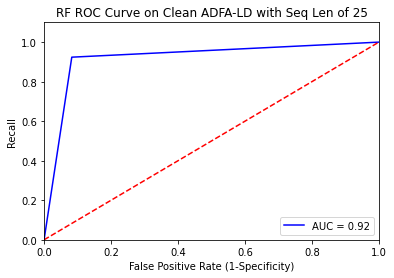

Test AUC: 0.921





/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[44691  3987]
 [ 6815 82362]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     48678
           1       0.95      0.92      0.94     89177

    accuracy                           0.92    137855
   macro avg       0.91      0.92      0.92    137855
weighted avg       0.92      0.92      0.92    137855

AUC: 0.92


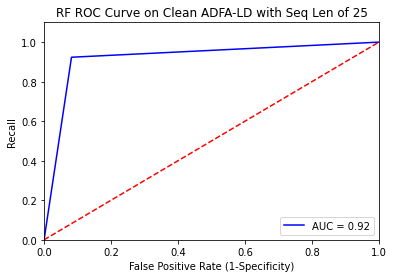

Test AUC: 0.921


In [55]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, 
                                      max_features='auto', bootstrap=True,verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, y_train)

## TESTING RF with clean data and unclean data
RF_clean_perf   = test_model(test_clean,   y_test_clean,   randomForest, 'RF', 'clean'); print('\n\n')
RF_unclean_perf = test_model(test_unclean, y_test_unclean, randomForest, 'RF', 'unclean')


# Save performance to text file
write_to_file( RF_clean_perf, 'RF', 'clean')
write_to_file( RF_unclean_perf, 'RF', 'unclean')

---------------------Testing with 90% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43645  4215]
 [ 6839 82170]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.09

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


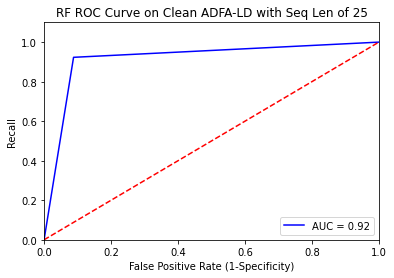

Test AUC: 0.918


---------------------Testing with 30% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43945  3915]
 [ 6915 82094]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


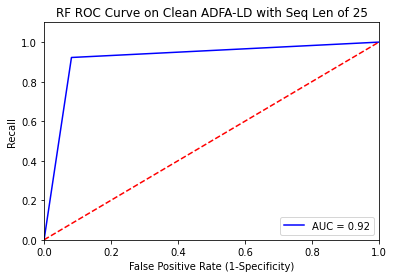

Test AUC: 0.920


---------------------Testing with 85% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43799  4061]
 [ 6701 82308]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


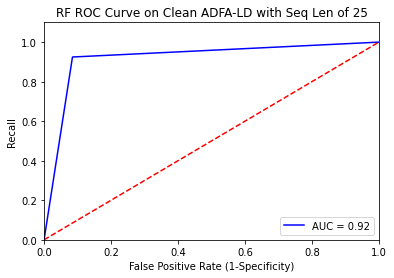

Test AUC: 0.920


---------------------Testing with 95% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43652  4208]
 [ 6176 82833]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.93
False Positive Rate: 0.09

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     47860
           1       0.95      0.93      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.92    136869
weighted avg       0.93      0.92      0.92    136869

AUC: 0.92


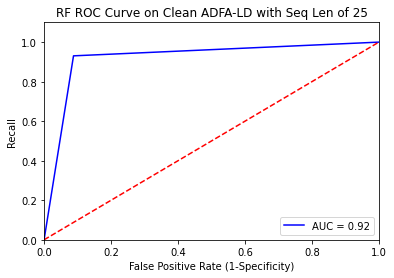

Test AUC: 0.921


---------------------Testing with 75% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43966  3894]
 [ 6579 82430]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.93
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.93      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.92    136869
weighted avg       0.93      0.92      0.92    136869

AUC: 0.92


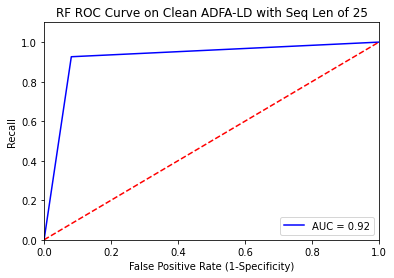

Test AUC: 0.922


---------------------Testing with 10% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43910  3950]
 [ 6794 82215]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


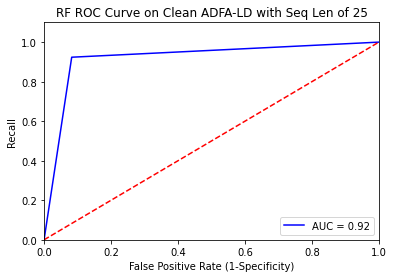

Test AUC: 0.921


---------------------Testing with 60% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43817  4043]
 [ 6854 82155]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


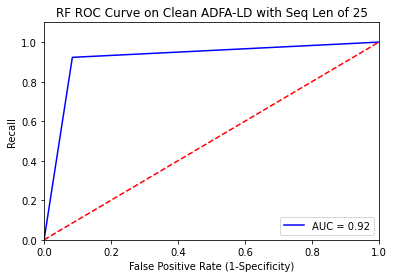

Test AUC: 0.919


---------------------Testing with 25% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43964  3896]
 [ 6786 82223]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.92    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


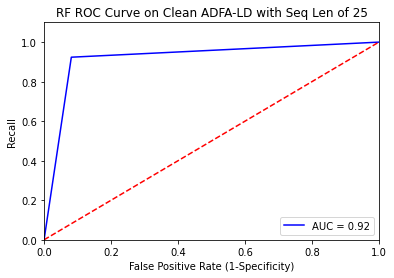

Test AUC: 0.921


---------------------Testing with 45% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43904  3956]
 [ 6750 82259]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.92    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


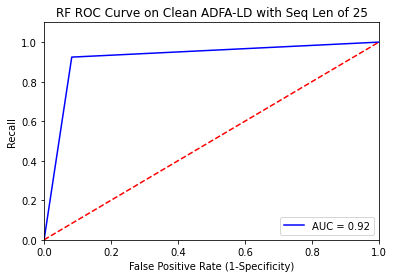

Test AUC: 0.921


---------------------Testing with 55% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43844  4016]
 [ 6786 82223]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


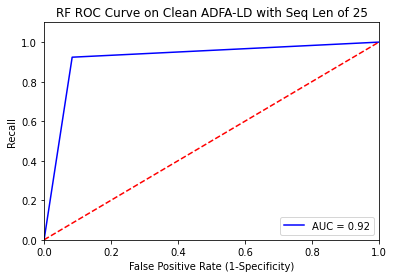

Test AUC: 0.920


---------------------Testing with 40% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43964  3896]
 [ 6770 82239]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.92    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


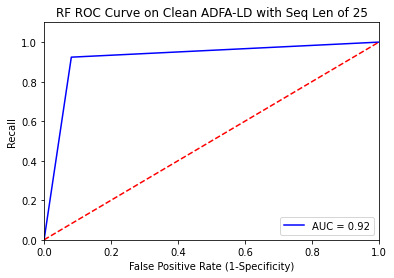

Test AUC: 0.921


---------------------Testing with 15% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43875  3985]
 [ 6802 82207]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


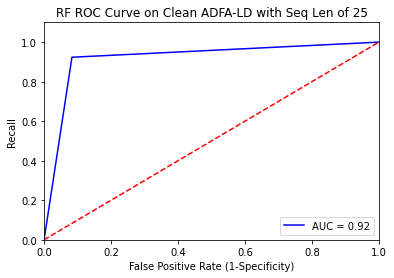

Test AUC: 0.920


---------------------Testing with 80% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43640  4220]
 [ 6721 82288]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.09

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


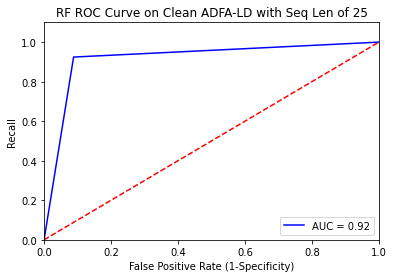

Test AUC: 0.918


---------------------Testing with 20% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43889  3971]
 [ 6797 82212]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


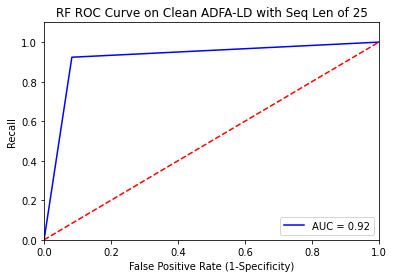

Test AUC: 0.920


---------------------Testing with 65% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43849  4011]
 [ 6878 82131]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


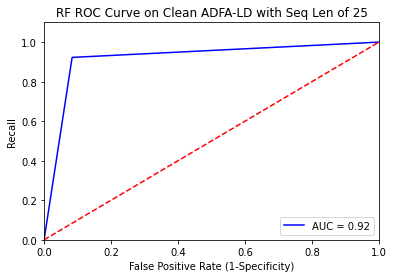

Test AUC: 0.919


---------------------Testing with 35% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43983  3877]
 [ 6806 82203]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.92    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


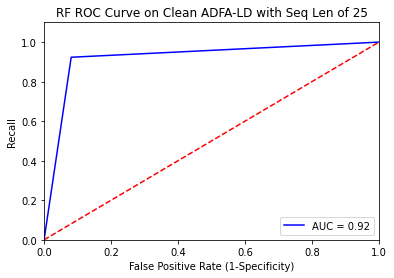

Test AUC: 0.921


---------------------Testing with 50% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43879  3981]
 [ 6668 82341]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.93
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.95      0.93      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.92    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


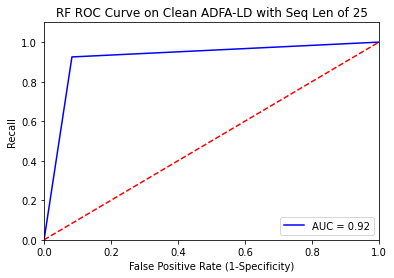

Test AUC: 0.921


---------------------Testing with 70% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[43722  4138]
 [ 6944 82065]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.92
False Positive Rate: 0.09

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89     47860
           1       0.95      0.92      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.91    136869
weighted avg       0.92      0.92      0.92    136869

AUC: 0.92


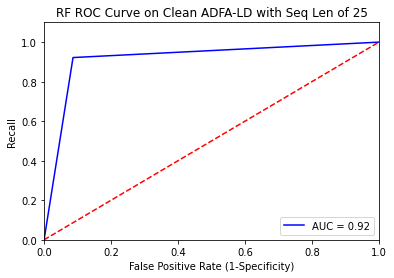

Test AUC: 0.918


---------------------Testing with 5% duplication---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[44032  3828]
 [ 6627 82382]]

Testing Accuracy: 0.92
Precision:0.96
Recall: 0.93
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     47860
           1       0.96      0.93      0.94     89009

    accuracy                           0.92    136869
   macro avg       0.91      0.92      0.92    136869
weighted avg       0.93      0.92      0.92    136869

AUC: 0.92


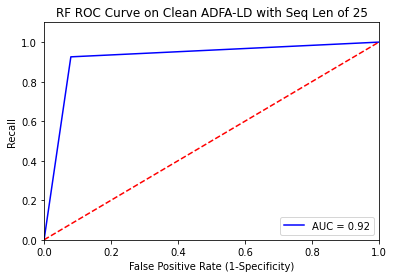

Test AUC: 0.923




In [56]:
# Test with Duplication 
test_with_duplication(randomForest, 'RF')

# **KNN**

This model classifies each observation based on 3 nearest neighbors with uniform weight.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=5, weights='uniform')
KNN.fit(svm_x_train, svm_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
#y_pred = KNN.predict(x_train)
#KNN_train = {}
#KNN_train['fpr'], KNN_train['tpr'], thresh = roc_curve(y_train, y_pred)
#KNN_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING KNN with clean data and unclean data
KNN_clean_perf   = test_model(test_clean,   y_test_clean,   KNN, 'KNN', 'clean'); print('\n\n')
KNN_unclean_perf = test_model(test_unclean, y_test_unclean, KNN, 'KNN', 'unclean')

# Save performance to text file
write_to_file( KNN_clean_perf, 'KNN', 'clean')
write_to_file( KNN_unclean_perf, 'KNN', 'unclean')


In [ ]:
# Test with Duplication 
test_with_duplication(KNN, 'KNN')

# **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier and train with training set
NaiveBayes = GaussianNB()
NaiveBayes.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
#y_pred = NaiveBayes.predict(x_train)
#NB_train = {}
#NB_train['fpr'], NB_train['tpr'], thresh = roc_curve(y_train, y_pred)
#NB_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING KNN with clean data and unclean data
NB_clean_perf   = test_model(test_clean,   y_test_clean,   NaiveBayes, 'NB', 'clean'); print('\n\n')
NB_unclean_perf = test_model(test_unclean, y_test_unclean, NaiveBayes, 'NB', 'unclean')


# Save performance to text file
write_to_file(NB_clean_perf, 'NB', 'clean')
write_to_file(NB_unclean_perf, 'NB', 'unclean')

In [ ]:
# Test with Duplication 
test_with_duplication(NaiveBayes, 'NB')

# **End**

In [ ]:
def plot_ROC_Clean_Unclean(clean, unclean, model_name):
  colors = {'unclean': 'lightcoral','clean': 'blue'}

  plt.plot(clean.get('fpr'), clean.get('tpr'), color=colors.get('clean'),  label= "AUC on Clean Data =" + str( round(clean.get('auc'), 3) ) )   
  plt.plot(unclean.get('fpr'), unclean.get('tpr'), color=colors.get('unclean'),  label= "AUC on Unclean Data =" + str( round(unclean.get('auc'), 3) ) )   
  plt.title(model_name +' Performance on Clean and Unclean Data')
  plt.legend()
  plt.show()

plot_ROC_Clean_Unclean(KM_clean_perf, KM_unclean_perf, 'KM')
plot_ROC_Clean_Unclean(LR_clean_perf, LR_unclean_perf, 'LR')
plot_ROC_Clean_Unclean(SVM_clean_perf, SVM_unclean_perf, 'SVM')
plot_ROC_Clean_Unclean(NN_clean_perf, NN_unclean_perf, 'NN')
plot_ROC_Clean_Unclean(DT_clean_perf, DT_unclean_perf, 'DT')
plot_ROC_Clean_Unclean(RF_clean_perf, RF_unclean_perf, 'RF')
plot_ROC_Clean_Unclean(KNN_clean_perf, KNN_unclean_perf, 'KNN')
plot_ROC_Clean_Unclean(NB_clean_perf, NB_unclean_perf, 'NB')


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC (DATA, SEQ_LEN, CLEAN ):
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))

  plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str( round(KM_test.get('auc'), 3) ) )   
  plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str( round(LR_test.get('auc'),3) ) )
  plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str( round(SVM_test.get('auc'), 3) ) )
  plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str( round(NN_test.get('auc'), 3) ) )
  plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str( round(DT_test.get('auc'), 3) ) )
  plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str( round(RF_test.get('auc'), 3) ) )
  plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str( round(KNN_test.get('auc'), 3) ) )
  plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str( round(NB_test.get('auc'), 3) ) )
  try:
    plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
    plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))
  except NameError:
    print('\nBERT_test and GPT_test do not exist\n')

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs %s on %s with seq len of %d' % (CLEAN, DATA, SEQ_LEN) )
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()


# Func load_dict loads the dictionary contents extracted from the text file to a given variable name (stored in varname str)
# Output is a global dict variable 
# Input format:
## varname: a string of variable name
## dictvar: a dict containing the dictionary contents extracted from the text file
def load_dict(varname, dictvar):
  exec('%s = {}' %(varname), globals() )
  for key, value in dictvar.items():
    #print(key,":", value)
    exec('%s[%s] = %s' % (varname, key, value), globals())

# Func localFile extract the contents of each dictionary variables and load them into a dictionary
# Output: All the dictionaries from the text file will be loaded to the program
#  Input format: a text file containing multiple dictionaries, where each dict has this format:
## KM_test = {'fpr': array([0.        , 0.86136255, 1.        ]), 'tpr': array([0.        , 0.49007655, 1.        ]), 'auc': 0.31435699935689737}
## This function reads in each line, process the string and load it as a dict variable
## In the end, this function loads global variables based on each line of text
def load_dict_from_text (localFile):
  with open(localFile) as infile_object : 
    lines = infile_object.read().splitlines()    # Open and read each line
    measures = {}                                # stores elements of a dict
  for line in lines: 
    words = line.strip("\n ").split(' = ')     # remove whitespace and split str to get var name. words[0] contains var name, words[1] contains the phrase that goes after '='
    values = words[1].strip(" {} ").split('), ') # remove the whitespace and '{}', then split the second part of words to get each element in dict
    # iterate through each key-value pairelement and process them to get specific key-value pair
    for v in values:  
      elements = v.split(': ')                   # split key value pair by ':'. elements[0] is key, elements[1] is value
      elements[1] = elements[1].strip('array(')  # remove 'array(' from the value
      #print(elements[0]) print(elements[1])
      measures[ elements[0] ] = elements[1]      # save the key-value pairs found in a line into measures dict

    load_dict(words[0], measures)                # load the content of measures dict into the variable name stored in words[0]
        


In [ ]:
       
#fileName = 'MIT Live Lpr-pm.txt'
#load_dict_from_text(fileName)

clean_status = 'clean' if CLEAN else 'unclean'
graph_multi_ROC(DATA, SEQ_WINDOW, clean_status)

## **Note**

Synthetic Sendmail dataset contains some sequences with only 6 system calls. Therefore we padded on the right with -1 on these small sequences, so that the sequence length can be 15.
After cleaning, there are 2021 unique normal sequences, while there are 423 unique intrusion sequences. This dataset is imbalanced. 

BERT and GPT significantly outperform the rest of the models with AUC above 0.95, while the others perform poorly on this dataset (AUC around 0.5)


